# Validate new compendia

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import pandas as pd
import plotnine as pn
import seaborn as sns
from textwrap import fill
from sklearn.preprocessing import MinMaxScaler
import umap
import matplotlib.pyplot as plt
from scripts import paths, utils

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# User param
# Threshold: if median accessory expression of PAO1 samples > threshold then this sample is binned as PAO1
threshold = 25

In [3]:
# Expression data with SRA labels
pao1_expression_filename = paths.PAO1_COMPENDIUM_LABEL
pa14_expression_filename = paths.PA14_COMPENDIUM_LABEL

# Expression data pre-binning
pao1_expression_prebin_filename = paths.PAO1_PREBIN_COMPENDIUM
pa14_expression_prebin_filename = paths.PA14_PREBIN_COMPENDIUM

# SRA annotations
sra_annotation_filename = paths.SAMPLE_TO_STRAIN_PROCESSED

In [4]:
# Load data
pao1_expression = pd.read_csv(pao1_expression_filename, sep="\t", index_col=0, header=0)
pa14_expression = pd.read_csv(pa14_expression_filename, sep="\t", index_col=0, header=0)

pao1_expression_prebin = pd.read_csv(
    pao1_expression_prebin_filename, sep="\t", index_col=0, header=0
)
pa14_expression_prebin = pd.read_csv(
    pa14_expression_prebin_filename, sep="\t", index_col=0, header=0
)

sra_annotation = pd.read_csv(sra_annotation_filename, sep="\t", index_col=0, header=0)

In [5]:
# Output filenames
pao1_expression_filename = (
    f"MR_median_acc_expression_pao1_compendium_{threshold}threshold.svg"
)
pa14_expression_filename = (
    f"MR_median_acc_expression_pa14_compendium_{threshold}threshold.svg"
)
pao1_dist_filename = (
    f"dist_median_acc_expression_pao1_compendium_{threshold}threshold.svg"
)
pa14_dist_filename = (
    f"dist_median_acc_expression_pa14_compendium_{threshold}threshold.svg"
)

## Get core and accessory annotations

In [6]:
pao1_annot_filename = paths.GENE_PAO1_ANNOT
pa14_annot_filename = paths.GENE_PA14_ANNOT

core_acc_dict = utils.get_my_core_acc_genes(
    pao1_annot_filename, pa14_annot_filename, pao1_expression, pa14_expression
)

Number of PAO1 core genes: 5366
Number of PA14 core genes: 5363
Number of PAO1 core genes in my dataset: 5361
Number of PA14 core genes in my dataset: 5357
Number of PAO1-specific genes: 203
Number of PA14-specific genes: 535


In [7]:
pao1_core = core_acc_dict["core_pao1"]
pa14_core = core_acc_dict["core_pa14"]
pao1_acc = core_acc_dict["acc_pao1"]
pa14_acc = core_acc_dict["acc_pa14"]

## Format data examining accessory genome

In [8]:
# Create accessory df for PAO1 compendium
# accessory gene ids | median accessory expression | strain label

# PAO1-only genes in PAO1 compendium
pao1_acc_pao1_compendium = pao1_expression[pao1_acc]
pao1_acc_pao1_compendium["median acc expression"] = pao1_acc_pao1_compendium.median(
    axis=1
)

# PA14-only genes in PAO1 compendium
pa14_acc_numeric = pa14_acc.copy()
pa14_acc_numeric.remove("Strain type")
pao1_binned_sample_ids = list(pao1_expression.index)
pa14_acc_pao1_compendium = pa14_expression_prebin.loc[
    pao1_binned_sample_ids, pa14_acc_numeric
]
pa14_acc_pao1_compendium["median acc expression"] = pa14_acc_pao1_compendium.median(
    axis=1
)

pao1_acc_pao1_compendium.head()

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,PA3153,PA3157,PA1224,PA0498,PA2185,PA3502,PA3155,PA3503,PA5086,PA1386,...,PA4638,PA0715,PA2730,PA4104,PA3158,PA2296,PA2103,PA3149,PA2139,median acc expression
ERX541572,1559.919677,2630.347318,14.792342,610.520287,14.792342,6.723792,1504.784585,21.516133,99.512117,583.625121,...,337.534344,3578.401949,638.760213,24.205650,2241.712157,20.171375,142.544384,2867.024786,1.344758,82.030259
ERX541573,2064.160518,3045.866826,22.258258,440.479203,17.572309,4.685949,1003.964565,44.516515,118.320211,278.813963,...,182.752010,4958.905490,209.696216,29.287181,1883.751483,29.287181,154.636316,2536.269876,1.171487,82.589850
ERX541574,2409.705414,3917.995184,15.814310,340.007655,29.651830,5.930366,911.299586,33.605408,150.235940,340.007655,...,247.098586,4910.343107,268.843262,19.767887,2022.254830,51.396506,152.212729,2623.198592,1.976789,87.967097
ERX541575,2172.122082,3284.845833,24.885196,1073.618443,15.997626,1.777514,1230.039673,24.885196,119.093437,223.966761,...,199.081566,6004.442221,277.292181,14.220112,1800.621661,24.885196,170.641342,3096.429351,1.777514,76.433101
ERX541576,2475.786645,2853.449015,20.981243,816.654526,12.911534,11.297592,1441.249983,22.595185,116.203806,161.394175,...,179.147534,6592.952051,426.080622,6.455767,1810.842644,46.804311,183.989360,4454.479231,1.613942,79.083146


In [9]:
pa14_acc_pao1_compendium.head()

,PA14_15475,PA14_28840,PA14_59520,PA14_16510,PA14_20530,PA14_58760,PA14_25410,PA14_31170,PA14_59950,PA14_22190,...,PA14_48470,PA14_14320,PA14_49510,PA14_69510,PA14_31150,PA14_46550,PA14_59190,PA14_04350,PA14_48490,median acc expression
ERX541572,2.767043,2.767043,2.767043,1776.441755,2.767043,24.903389,41.505648,2.767043,2.767043,2.767043,...,8.301130,19.369303,2.767043,5.534086,2.767043,2.767043,2.767043,63.641994,2.767043,5.534086
ERX541573,4.051770,4.051770,2.701180,1173.662575,1.350590,20.258848,56.724773,1.350590,1.350590,1.350590,...,5.402359,14.856488,2.701180,2.701180,1.350590,1.350590,1.350590,97.242469,1.350590,2.701180
ERX541574,2.416268,2.416268,1.208134,1338.612202,1.208134,18.122006,20.538274,1.208134,1.208134,1.208134,...,13.289471,8.456936,1.208134,2.416268,1.208134,1.208134,1.208134,112.356439,6.040669,2.416268
ERX541575,2.005402,6.016205,4.010803,1173.159913,2.005402,38.102630,26.070220,2.005402,2.005402,2.005402,...,10.027008,18.048614,4.010803,2.005402,4.010803,2.005402,2.005402,104.280881,10.027008,4.010803
ERX541576,5.507165,9.178608,1.835722,978.439624,3.671443,22.028659,40.385876,1.835722,3.671443,1.835722,...,11.014330,20.192938,1.835722,5.507165,1.835722,3.671443,1.835722,104.636132,5.507165,3.671443


In [10]:
# Merge PAO1 and PA14 accessory dataframes
pao1_pa14_acc_pao1_compendium_label = pao1_acc_pao1_compendium.merge(
    pa14_acc_pao1_compendium,
    left_index=True,
    right_index=True,
    suffixes=["_pao1", "_pa14"],
)

pao1_pa14_acc_pao1_compendium_label.head()

,PA3153,PA3157,PA1224,PA0498,PA2185,PA3502,PA3155,PA3503,PA5086,PA1386,...,PA14_48470,PA14_14320,PA14_49510,PA14_69510,PA14_31150,PA14_46550,PA14_59190,PA14_04350,PA14_48490,median acc expression_pa14
ERX541572,1559.919677,2630.347318,14.792342,610.520287,14.792342,6.723792,1504.784585,21.516133,99.512117,583.625121,...,8.301130,19.369303,2.767043,5.534086,2.767043,2.767043,2.767043,63.641994,2.767043,5.534086
ERX541573,2064.160518,3045.866826,22.258258,440.479203,17.572309,4.685949,1003.964565,44.516515,118.320211,278.813963,...,5.402359,14.856488,2.701180,2.701180,1.350590,1.350590,1.350590,97.242469,1.350590,2.701180
ERX541574,2409.705414,3917.995184,15.814310,340.007655,29.651830,5.930366,911.299586,33.605408,150.235940,340.007655,...,13.289471,8.456936,1.208134,2.416268,1.208134,1.208134,1.208134,112.356439,6.040669,2.416268
ERX541575,2172.122082,3284.845833,24.885196,1073.618443,15.997626,1.777514,1230.039673,24.885196,119.093437,223.966761,...,10.027008,18.048614,4.010803,2.005402,4.010803,2.005402,2.005402,104.280881,10.027008,4.010803
ERX541576,2475.786645,2853.449015,20.981243,816.654526,12.911534,11.297592,1441.249983,22.595185,116.203806,161.394175,...,11.014330,20.192938,1.835722,5.507165,1.835722,3.671443,1.835722,104.636132,5.507165,3.671443


In [11]:
# Create accessory df for PA14 compendium
# accessory gene ids | median accessory expression | strain label

# PA14-only genes in PA14 compendium
pa14_acc_pa14_compendium = pa14_expression[pa14_acc]
pa14_acc_pa14_compendium["median acc expression"] = pa14_acc_pa14_compendium.median(
    axis=1
)

# PAO1-only genes in PA14 compendium
pao1_acc_numeric = pao1_acc.copy()
pao1_acc_numeric.remove("Strain type")
pa14_binned_sample_ids = list(pa14_expression.index)
pao1_acc_pa14_compendium = pao1_expression_prebin.loc[
    pa14_binned_sample_ids, pao1_acc_numeric
]
pao1_acc_pa14_compendium["median acc expression"] = pao1_acc_pa14_compendium.median(
    axis=1
)

pa14_acc_pa14_compendium.head()

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,PA14_15475,PA14_28840,PA14_59520,PA14_16510,PA14_20530,PA14_58760,PA14_25410,PA14_31170,PA14_59950,PA14_22190,...,PA14_48470,PA14_14320,PA14_49510,PA14_69510,PA14_31150,PA14_46550,PA14_59190,PA14_04350,PA14_48490,median acc expression
ERX1477379,96.930001,3693.543197,25.507895,1494.762647,380.577793,3943.520568,29.589158,10.203158,52.036106,371.394951,...,27.548527,5.101579,7506.463342,987.665695,459.142110,829.516746,1940.640652,98.970633,32.650106,117.336317
ERX1477380,80.507789,2764.697123,33.992178,1251.150682,159.822871,1678.140143,23.257806,5.367186,33.395824,147.895791,...,35.184886,4.770832,5268.191195,595.757641,295.791582,551.031092,1171.239247,107.940073,29.221346,96.311170
ERX1477381,70.529716,2157.542894,13.883802,1292.859680,133.839855,1462.797422,30.544365,6.664225,22.769436,107.182955,...,52.758449,8.330281,3834.150872,467.606465,271.567175,403.740974,962.425183,103.850842,24.990844,83.025138
ERX2174773,11.141891,861.791199,5.912024,987.308017,32.970903,645.320164,23.648096,27.741036,6.821566,38.882927,...,23.648096,7.731108,301.740612,258.992131,36.381686,140.524264,228.749854,73.445530,30.697048,34.562602
ERX2174774,12.975503,1039.537431,4.990578,842.409593,32.438758,697.433298,22.707131,26.450064,9.731627,31.690171,...,20.211842,7.236338,274.481799,239.298223,29.943469,150.465931,186.398094,95.070514,36.930278,36.431221


In [12]:
pao1_acc_pa14_compendium.head()

,PA3153,PA3157,PA1224,PA0498,PA2185,PA3502,PA3155,PA3503,PA5086,PA1386,...,PA4638,PA0715,PA2730,PA4104,PA3158,PA2296,PA2103,PA3149,PA2139,median acc expression
ERX1477379,1.140150,1.140150,3.420450,1.140150,1.140150,1.140150,1.140150,1.140150,657.866528,1.140150,...,368.268437,1.140150,1.140150,1.140150,1.140150,1.140150,1.140150,1.140150,1.140150,1.140150
ERX1477380,0.655574,0.655574,8.522459,0.655574,0.655574,0.655574,0.655574,0.655574,397.277702,0.655574,...,295.663768,0.655574,0.655574,0.655574,0.655574,0.655574,0.655574,0.655574,1.311148,0.655574
ERX1477381,0.612870,0.612870,4.902959,0.612870,0.612870,0.612870,0.612870,0.612870,278.855777,0.612870,...,224.923231,0.612870,0.612870,0.612870,0.612870,0.612870,0.612870,0.612870,0.612870,0.612870
ERX2174773,0.254462,0.254462,2.035699,0.254462,0.254462,0.254462,0.254462,0.254462,70.740555,0.254462,...,24.682856,0.254462,0.254462,0.254462,0.254462,0.254462,0.254462,0.254462,5.598173,0.254462
ERX2174774,0.277911,0.277911,2.501200,0.277911,0.277911,0.277911,0.277911,0.277911,56.693856,0.277911,...,23.344529,0.277911,0.277911,0.277911,0.277911,0.277911,0.277911,0.277911,10.004798,0.277911


In [13]:
# Merge PAO1 and PA14 accessory dataframes
pao1_pa14_acc_pa14_compendium_label = pa14_acc_pa14_compendium.merge(
    pao1_acc_pa14_compendium,
    left_index=True,
    right_index=True,
    suffixes=["_pa14", "_pao1"],
)

pao1_pa14_acc_pa14_compendium_label.head()

,PA14_15475,PA14_28840,PA14_59520,PA14_16510,PA14_20530,PA14_58760,PA14_25410,PA14_31170,PA14_59950,PA14_22190,...,PA4638,PA0715,PA2730,PA4104,PA3158,PA2296,PA2103,PA3149,PA2139,median acc expression_pao1
ERX1477379,96.930001,3693.543197,25.507895,1494.762647,380.577793,3943.520568,29.589158,10.203158,52.036106,371.394951,...,368.268437,1.140150,1.140150,1.140150,1.140150,1.140150,1.140150,1.140150,1.140150,1.140150
ERX1477380,80.507789,2764.697123,33.992178,1251.150682,159.822871,1678.140143,23.257806,5.367186,33.395824,147.895791,...,295.663768,0.655574,0.655574,0.655574,0.655574,0.655574,0.655574,0.655574,1.311148,0.655574
ERX1477381,70.529716,2157.542894,13.883802,1292.859680,133.839855,1462.797422,30.544365,6.664225,22.769436,107.182955,...,224.923231,0.612870,0.612870,0.612870,0.612870,0.612870,0.612870,0.612870,0.612870,0.612870
ERX2174773,11.141891,861.791199,5.912024,987.308017,32.970903,645.320164,23.648096,27.741036,6.821566,38.882927,...,24.682856,0.254462,0.254462,0.254462,0.254462,0.254462,0.254462,0.254462,5.598173,0.254462
ERX2174774,12.975503,1039.537431,4.990578,842.409593,32.438758,697.433298,22.707131,26.450064,9.731627,31.690171,...,23.344529,0.277911,0.277911,0.277911,0.277911,0.277911,0.277911,0.277911,10.004798,0.277911


In [14]:
"Strain type" in pao1_pa14_acc_pa14_compendium_label.columns

True

## Accessory plots

In [15]:
pao1_pa14_acc_pao1_compendium_label[
    "Strain type"
] = pao1_pa14_acc_pao1_compendium_label["Strain type"].fillna("NA")
pao1_pa14_acc_pa14_compendium_label[
    "Strain type"
] = pao1_pa14_acc_pa14_compendium_label["Strain type"].fillna("NA")

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


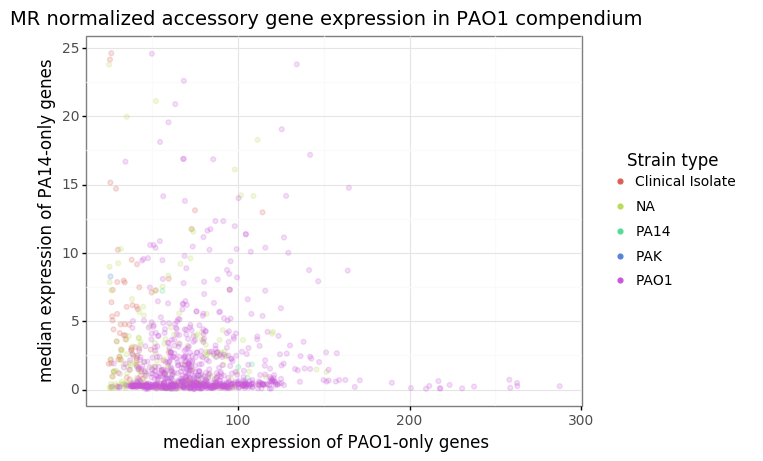

<ggplot: (8750836948109)>


/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: MR_median_acc_expression_pao1_compendium_25threshold.svg
  warn('Filename: {}'.format(filename))
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [16]:
# Plot accessory gene expression in PAO1 compendium
# Note: commented out code is for plotting figure for Georgia's manuscript
colors = {
    "Clinical Isolate": "#89A45E",
    "PA14": "#895881",
    "PAK": "#EF8B46",
    "PAO1": "#C6A9B5",
    "NA": "#D8DAEB",
}
fig1 = pn.ggplot(
    pao1_pa14_acc_pao1_compendium_label,
    pn.aes(x="median acc expression_pao1", y="median acc expression_pa14"),
)
# fig1 += pn.scale_color_manual(values=colors)
fig1 += pn.geom_point(pn.aes(color="Strain type"), alpha=0.2)
fig1 += pn.labs(
    x="median expression of PAO1-only genes",
    y="median expression of PA14-only genes",
    title="MR normalized accessory gene expression in PAO1 compendium",
    # title="Accessory gene expression in PAO1 compendium",
)
fig1 += pn.theme_bw()
fig1 += pn.theme(
    legend_title_align="center",
    plot_background=pn.element_rect(fill="white"),
    legend_key=pn.element_rect(fill="white", colour="white"),
    legend_title=pn.element_text(family="sans-serif", size=12),
    legend_text=pn.element_text(family="sans-serif", size=10),
    plot_title=pn.element_text(family="sans-serif", size=14),
    axis_text=pn.element_text(family="sans-serif", size=10),
    axis_title=pn.element_text(family="sans-serif", size=12),
)
fig1 += pn.guides(colour=pn.guide_legend(override_aes={"alpha": 1}))

print(fig1)

fig1.save(filename=pao1_expression_filename, format="svg", dpi=300)

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


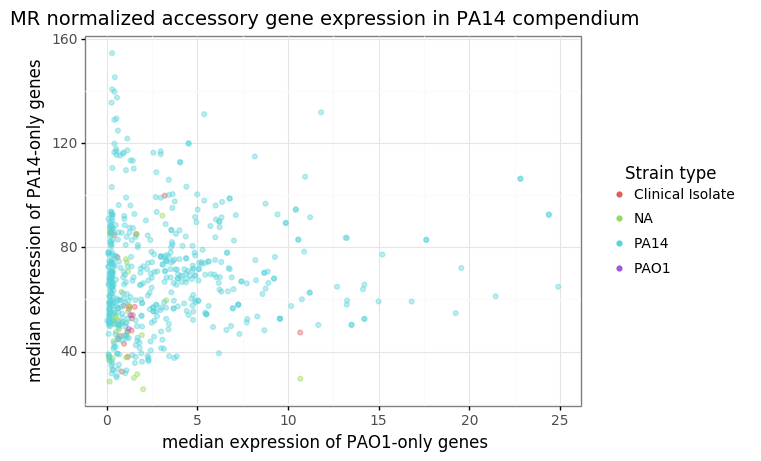

<ggplot: (8750837887837)>


/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: MR_median_acc_expression_pa14_compendium_25threshold.svg
  warn('Filename: {}'.format(filename))
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [17]:
# Plot accessory gene expression in PA14 compendium
fig2 = pn.ggplot(
    pao1_pa14_acc_pa14_compendium_label,
    pn.aes(x="median acc expression_pao1", y="median acc expression_pa14"),
)
# fig2 += pn.scale_color_manual(values=colors)
fig2 += pn.geom_point(pn.aes(color="Strain type"), alpha=0.4)
fig2 += pn.labs(
    x="median expression of PAO1-only genes",
    y="median expression of PA14-only genes",
    title="MR normalized accessory gene expression in PA14 compendium",
    # title="Accessory gene expression in PA14 compendium",
)
fig2 += pn.theme_bw()
fig2 += pn.theme(
    legend_title_align="center",
    plot_background=pn.element_rect(fill="white"),
    legend_key=pn.element_rect(fill="white", colour="white"),
    legend_title=pn.element_text(family="sans-serif", size=12),
    legend_text=pn.element_text(family="sans-serif", size=10),
    plot_title=pn.element_text(family="sans-serif", size=14),
    axis_text=pn.element_text(family="sans-serif", size=10),
    axis_title=pn.element_text(family="sans-serif", size=12),
)
fig2 += pn.guides(colour=pn.guide_legend(override_aes={"alpha": 1}))

print(fig2)

fig2.save(filename=pa14_expression_filename, format="svg", dpi=300)

These plots are showing the median expression of PAO1 genes (PAO1 accessory genes) on the x-axis and the median expression of PA14-only genes (PA14 accessory genes) on the y-axis.
Each point is a sample.

If we binned our samples accurately then for samples within our binned PAO1 compendium, we expect that samples will align along the PAO1-only axis. Similarly, for samples within our binned PA14 compendium, we expect that samples will align along the PA14-axis.

## Check

What is the distribution of median accessory gene expression look like for PAO1 binned but non-PAO1 SRA labeled samples compared to PAO1 binned and PAO1 SRA labeled samples? Looks like the non-PAO1 labeled samples may be clustered at the bottom of the distribution. Similarly for PA14 binned samples.

Should we filter out samples with low median PAO1 accessory gene expression? There was already filtering for low expression counts in the Salmon processing step to ensure that we are getting "real" expression.

Based on the distribution, I increased the threshold used to bin samples.

See visualization results using a threshold of median accessory expression > 0: [PR#20](https://github.com/greenelab/core-accessory-interactome/pull/20)

New visualization results using a threshold of median accessory expression > 10 can be seen below. Looks like the distribution is more similar

In [18]:
# Get PAO1 samples that are labeled PAO1 and non-PAO1
pao1_binned_pao1_sra = pao1_pa14_acc_pao1_compendium_label.loc[
    pao1_pa14_acc_pao1_compendium_label["Strain type"] == "PAO1",
    "median acc expression_pao1",
]

pao1_binned_non_pao1_sra = pao1_pa14_acc_pao1_compendium_label.loc[
    pao1_pa14_acc_pao1_compendium_label["Strain type"] != "PAO1",
    "median acc expression_pao1",
]

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


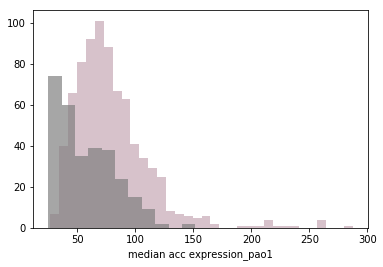

In [19]:
f = sns.distplot(
    pao1_binned_pao1_sra, color="#C6A9B5", kde=False, hist_kws={"alpha": 0.7}
)
f = sns.distplot(
    pao1_binned_non_pao1_sra, color="grey", kde=False, hist_kws={"alpha": 0.7}
)
if threshold == 0:
    plt.axvline(25, 0, 100, color="red")

f.figure.savefig(pao1_dist_filename, format="svg", dpi=300)

In [20]:
# Get PA14 samples that are labeled PA14 and non-PA14
pa14_binned_pa14_sra = pao1_pa14_acc_pa14_compendium_label.loc[
    pao1_pa14_acc_pa14_compendium_label["Strain type"] == "PA14",
    "median acc expression_pa14",
]

pa14_binned_non_pa14_sra = pao1_pa14_acc_pa14_compendium_label.loc[
    pao1_pa14_acc_pa14_compendium_label["Strain type"] != "PA14",
    "median acc expression_pa14",
]

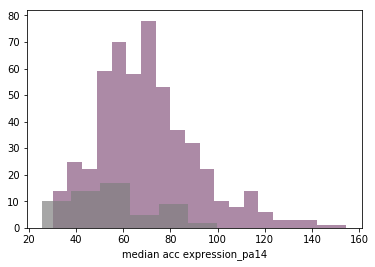

In [21]:
g = sns.distplot(
    pa14_binned_pa14_sra, color="#895881", kde=False, hist_kws={"alpha": 0.7}
)
g = sns.distplot(
    pa14_binned_non_pa14_sra, color="grey", kde=False, hist_kws={"alpha": 0.7}
)
if threshold == 0:
    plt.axvline(25, 0, 100, color="red")

g.figure.savefig(pa14_dist_filename, format="svg", dpi=300)

## Core plots

### using PAO1 reference

In [22]:
# Get core gene expression in PAO1 compendium
pao1_core_pao1_compendium = pao1_expression[pao1_core]

# Get core genes expression in PA14 compendium
pa14_core_pa14_compendium = pa14_expression[pa14_core]

In [23]:
# Get mapping between PAO1 and PA14 genes using PAO1 and PA14 references
gene_mapping_pa14 = utils.get_pao1_pa14_gene_map(pa14_annot_filename, "pa14")
pa14_core_to_pao1_core = gene_mapping_pa14.loc[pa14_core, "PAO1_ID"]

# Convert PA14 core ids to PAO1 core ids so we can merge
pao1_core_pa14_compendium = pa14_core_pa14_compendium.rename(
    columns=pa14_core_to_pao1_core
)

In [24]:
# Get mapping between PAO1 and PA14 genes using PAO1 and PA14 references
gene_mapping_pao1 = utils.get_pao1_pa14_gene_map(pao1_annot_filename, "pao1")
pao1_core_to_pa14_core = gene_mapping_pao1.loc[pao1_core, "PA14_ID"]

# Convert PAO1 core ids to PA14 core ids so we can merge
pa14_core_pao1_compendium = pao1_core_pao1_compendium.rename(
    columns=pao1_core_to_pa14_core
)

In [25]:
# Check for 1 to many mappings that will result in duplicate gene ids
if pao1_core_pa14_compendium.columns.duplicated().any():
    deduplicated_columns = list(
        pao1_core_pa14_compendium.columns[
            ~pao1_core_pa14_compendium.columns.duplicated(keep=False)
        ]
    )
    pao1_core_pa14_compendium = pao1_core_pa14_compendium[deduplicated_columns]

if pao1_core_pao1_compendium.columns.duplicated().any():
    deduplicated_columns = list(
        pao1_core_pao1_compendium.columns[
            ~pao1_core_pao1_compendium.columns.duplicated(keep=False)
        ]
    )
    pao1_core_pao1_compendium = pao1_core_pao1_compendium[deduplicated_columns]

if pa14_core_pao1_compendium.columns.duplicated().any():
    deduplicated_columns = list(
        pa14_core_pao1_compendium.columns[
            ~pa14_core_pao1_compendium.columns.duplicated(keep=False)
        ]
    )
    pa14_core_pao1_compendium = pa14_core_pao1_compendium[deduplicated_columns]

In [26]:
# Get shared core genes
shared_pao1_core_genes = list(
    set(pao1_core_pao1_compendium.columns).intersection(
        pao1_core_pa14_compendium.columns
    )
)

shared_pa14_core_genes = list(
    set(pa14_core_pao1_compendium.columns).intersection(
        pa14_core_pa14_compendium.columns
    )
)

print(len(shared_pao1_core_genes))
print(len(shared_pa14_core_genes))

# re-order columns to match
pao1_core_pao1_compendium = pao1_core_pao1_compendium[shared_pao1_core_genes]
pao1_core_pa14_compendium = pao1_core_pa14_compendium[shared_pao1_core_genes]
pa14_core_pa14_compendium = pa14_core_pa14_compendium[shared_pa14_core_genes]
pa14_core_pao1_compendium = pa14_core_pao1_compendium[shared_pa14_core_genes]

5348
5349


In [27]:
print(pao1_core_pao1_compendium.shape)
print(pao1_core_pa14_compendium.shape)

print(pa14_core_pa14_compendium.shape)
print(pa14_core_pao1_compendium.shape)

(1081, 5348)
(576, 5348)
(576, 5349)
(1081, 5349)


In [28]:
# Add labels
pao1_core_pao1_compendium["our label"] = "PAO1"
pao1_core_pa14_compendium["our label"] = "PA14"
pa14_core_pa14_compendium["our label"] = "PA14"
pa14_core_pao1_compendium["our label"] = "PAO1"

pao1_core_pao1_compendium["sra label"] = sra_annotation.loc[
    list(pao1_core_pao1_compendium.index), "Strain type"
]
pao1_core_pa14_compendium["sra label"] = sra_annotation.loc[
    list(pao1_core_pa14_compendium.index), "Strain type"
]

pa14_core_pa14_compendium["sra label"] = sra_annotation.loc[
    list(pa14_core_pa14_compendium.index), "Strain type"
]
pa14_core_pao1_compendium["sra label"] = sra_annotation.loc[
    list(pa14_core_pao1_compendium.index), "Strain type"
]

In [29]:
# Merge on columns
pao1_core_label = pd.concat([pao1_core_pao1_compendium, pao1_core_pa14_compendium])
print(pao1_core_label.shape)
pao1_core_label.head()

(1657, 5350)


,PA5127,PA4441,PA3100,PA4061,PA4419,PA1416,PA3753,PA1878,PA3888,PA5058,...,PA1164,PA1614,PA3297,PA0959,PA0075,PA2757,PA3045,PA3876,our label,sra label
ERX541572,348.292411,556.729954,190.955685,584.969879,736.927572,29.584684,102.201634,34.963717,22.860892,108.925426,...,840.473964,227.264160,1935.107255,492.181553,274.330702,22.860892,61.858884,65.893159,PAO1,NaN
ERX541573,236.640423,425.249868,133.549545,643.146495,564.656850,31.630156,246.012321,25.772719,35.144617,147.607392,...,520.140335,265.927604,953.590614,330.359402,153.464829,16.400821,59.745849,224.925550,PAO1,NaN
ERX541574,373.613062,375.589851,181.864560,1047.698006,478.382863,21.744676,233.261065,31.628619,29.651830,183.841348,...,423.032780,423.032780,865.833446,215.469967,343.961232,29.651830,45.466140,213.493179,PAO1,NaN
ERX541575,245.296929,476.373746,131.536034,769.663553,591.912155,12.442598,261.294555,23.107682,35.550280,188.416482,...,460.376121,227.521789,936.749867,380.387991,238.186873,30.217738,53.325419,122.648465,PAO1,NaN
ERX541576,271.142214,547.126253,106.520156,664.944001,608.456040,22.595185,284.053748,38.734602,32.278835,167.849942,...,477.726758,237.249437,945.769866,385.732078,242.091263,46.804311,61.329787,83.924971,PAO1,NaN


In [30]:
# Merge
pa14_core_label = pd.concat([pa14_core_pa14_compendium, pa14_core_pao1_compendium])
print(pa14_core_label.shape)
pa14_core_label.head()

(1657, 5351)


,PA14_71430,PA14_62290,PA14_70450,PA14_06270,PA14_30520,PA14_20350,PA14_71180,PA14_13350,PA14_36110,PA14_04670,...,PA14_51290,PA14_56240,PA14_00240,PA14_27910,PA14_02620,PA14_68610,PA14_23630,PA14_71030,our label,sra label
ERX1477379,532.604848,330.582319,2325.299709,54.076737,9.182842,4.081263,43.873579,343.846425,14.284421,283.647792,...,654.022428,509.137584,141.823896,205.083476,52.036106,409.146636,64.279895,233.652318,PA14,PA14
ERX1477380,723.973750,397.171761,2725.337759,69.773417,23.854160,3.578124,47.111966,387.033743,12.523434,378.088433,...,450.247267,567.729004,140.739543,155.648393,35.781240,259.413988,79.911435,192.025987,PA14,PA14
ERX1477381,936.878986,471.493930,2580.165839,86.634927,26.656901,5.553521,56.645914,329.323793,9.996338,496.484774,...,450.390550,644.208432,150.500418,142.725489,68.863660,287.672386,108.849011,166.050277,PA14,PA14
ERX2174773,269.224480,53.890373,655.552514,35.926915,21.829012,6.366795,55.709457,305.378781,4.775096,331.755504,...,333.574588,1613.527796,149.392300,25.694566,52.298674,221.246131,88.452975,219.881818,PA14,PA14
ERX2174774,314.905482,59.387880,568.426852,35.932163,21.709015,6.487752,54.646831,483.587024,11.478330,316.901713,...,281.718137,1574.277880,130.004561,24.952891,36.680749,177.415054,88.333233,197.377366,PA14,PA14


In [31]:
# Drop label columns
pao1_core_numeric = pao1_core_label.drop(["our label", "sra label"], axis=1)
pa14_core_numeric = pa14_core_label.drop(["our label", "sra label"], axis=1)

In [32]:
pao1_core_numeric.head()

,PA5127,PA4441,PA3100,PA4061,PA4419,PA1416,PA3753,PA1878,PA3888,PA5058,...,PA4438,PA2215,PA1164,PA1614,PA3297,PA0959,PA0075,PA2757,PA3045,PA3876
ERX541572,348.292411,556.729954,190.955685,584.969879,736.927572,29.584684,102.201634,34.963717,22.860892,108.925426,...,1293.657525,17.481858,840.473964,227.264160,1935.107255,492.181553,274.330702,22.860892,61.858884,65.893159
ERX541573,236.640423,425.249868,133.549545,643.146495,564.656850,31.630156,246.012321,25.772719,35.144617,147.607392,...,1517.075977,44.516515,520.140335,265.927604,953.590614,330.359402,153.464829,16.400821,59.745849,224.925550
ERX541574,373.613062,375.589851,181.864560,1047.698006,478.382863,21.744676,233.261065,31.628619,29.651830,183.841348,...,1804.808074,37.558985,423.032780,423.032780,865.833446,215.469967,343.961232,29.651830,45.466140,213.493179
ERX541575,245.296929,476.373746,131.536034,769.663553,591.912155,12.442598,261.294555,23.107682,35.550280,188.416482,...,1430.898753,24.885196,460.376121,227.521789,936.749867,380.387991,238.186873,30.217738,53.325419,122.648465
ERX541576,271.142214,547.126253,106.520156,664.944001,608.456040,22.595185,284.053748,38.734602,32.278835,167.849942,...,1538.086488,27.437010,477.726758,237.249437,945.769866,385.732078,242.091263,46.804311,61.329787,83.924971


In [33]:
# 0-1 normalize per gene
scaler = MinMaxScaler()

# Fitting
normalized_pao1_core_numeric = scaler.fit_transform(pao1_core_numeric)
normalized_pao1_core_numeric_df = pd.DataFrame(
    normalized_pao1_core_numeric,
    columns=pao1_core_numeric.columns,
    index=pao1_core_numeric.index,
)

normalized_pa14_core_numeric = scaler.fit_transform(pa14_core_numeric)
normalized_pa14_core_numeric_df = pd.DataFrame(
    normalized_pa14_core_numeric,
    columns=pa14_core_numeric.columns,
    index=pa14_core_numeric.index,
)

In [34]:
# model_pao1 = pca.fit(normalized_pao1_expression_numeric_df)
model_pao1 = umap.UMAP(random_state=123).fit(normalized_pao1_core_numeric_df)

normalized_pao1_core_encoded = model_pao1.transform(normalized_pao1_core_numeric_df)

normalized_pao1_core_encoded_df = pd.DataFrame(
    data=normalized_pao1_core_encoded,
    index=normalized_pao1_core_numeric_df.index,
    columns=["1", "2"],
)

# Add back label
normalized_pao1_core_encoded_df[["our label", "sra label"]] = pao1_core_label[
    ["our label", "sra label"]
]

In [35]:
# model_pao1 = pca.fit(normalized_pao1_expression_numeric_df)
model_pa14 = umap.UMAP(random_state=123).fit(normalized_pa14_core_numeric_df)

normalized_pa14_core_encoded = model_pa14.transform(normalized_pa14_core_numeric_df)

normalized_pa14_core_encoded_df = pd.DataFrame(
    data=normalized_pa14_core_encoded,
    index=normalized_pa14_core_numeric_df.index,
    columns=["1", "2"],
)

# Add back label
normalized_pa14_core_encoded_df[["our label", "sra label"]] = pa14_core_label[
    ["our label", "sra label"]
]

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


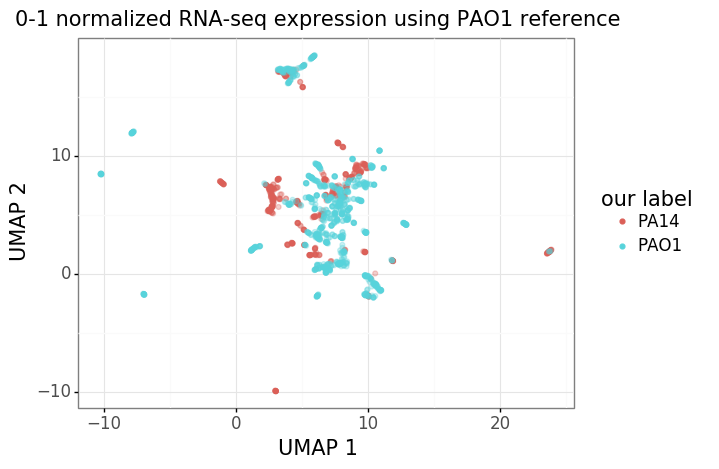

<ggplot: (8750833542265)>


In [36]:
# Plot core gene expression in PAO1 reference
fig3 = pn.ggplot(normalized_pao1_core_encoded_df, pn.aes(x="1", y="2"))
fig3 += pn.geom_point(pn.aes(color="our label"), alpha=0.3)
fig3 += pn.labs(
    x="UMAP 1",
    y="UMAP 2",
    title="0-1 normalized RNA-seq expression using PAO1 reference",
)
fig3 += pn.theme_bw()
fig3 += pn.theme(
    legend_title_align="center",
    plot_background=pn.element_rect(fill="white"),
    legend_key=pn.element_rect(fill="white", colour="white"),
    legend_title=pn.element_text(family="sans-serif", size=15),
    legend_text=pn.element_text(family="sans-serif", size=12),
    plot_title=pn.element_text(family="sans-serif", size=15),
    axis_text=pn.element_text(family="sans-serif", size=12),
    axis_title=pn.element_text(family="sans-serif", size=15),
)
fig3 += pn.guides(colour=pn.guide_legend(override_aes={"alpha": 1}))

print(fig3)

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


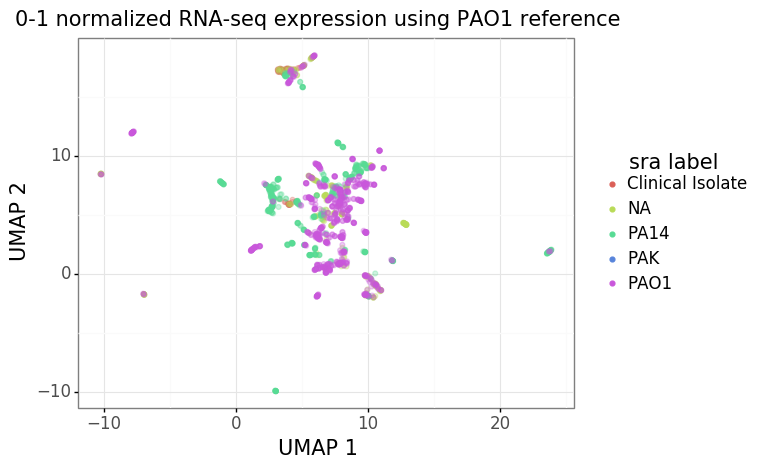

<ggplot: (8750834745297)>


In [37]:
# Plot core gene expression in PAO1 reference
normalized_pao1_core_encoded_df["sra label"] = normalized_pao1_core_encoded_df[
    "sra label"
].fillna("NA")
fig4 = pn.ggplot(normalized_pao1_core_encoded_df, pn.aes(x="1", y="2"))
fig4 += pn.geom_point(pn.aes(color="sra label"), alpha=0.3)
fig4 += pn.labs(
    x="UMAP 1",
    y="UMAP 2",
    title="0-1 normalized RNA-seq expression using PAO1 reference",
)
fig4 += pn.theme_bw()
fig4 += pn.theme(
    legend_title_align="center",
    plot_background=pn.element_rect(fill="white"),
    legend_key=pn.element_rect(fill="white", colour="white"),
    legend_title=pn.element_text(family="sans-serif", size=15),
    legend_text=pn.element_text(family="sans-serif", size=12),
    plot_title=pn.element_text(family="sans-serif", size=15),
    axis_text=pn.element_text(family="sans-serif", size=12),
    axis_title=pn.element_text(family="sans-serif", size=15),
)
fig4 += pn.guides(colour=pn.guide_legend(override_aes={"alpha": 1}))

print(fig4)

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


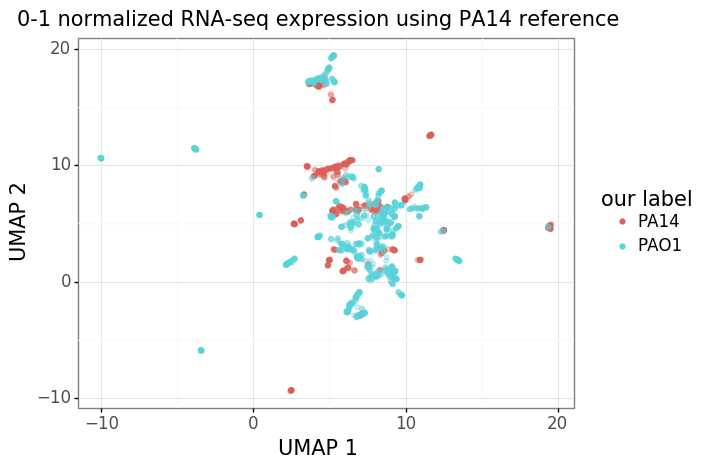

<ggplot: (8750833605689)>


In [38]:
# Plot core gene expression in PA14 reference
fig5 = pn.ggplot(normalized_pa14_core_encoded_df, pn.aes(x="1", y="2"))
fig5 += pn.geom_point(pn.aes(color="our label"), alpha=0.3)
fig5 += pn.labs(
    x="UMAP 1",
    y="UMAP 2",
    title="0-1 normalized RNA-seq expression using PA14 reference",
)
fig5 += pn.theme_bw()
fig5 += pn.theme(
    legend_title_align="center",
    plot_background=pn.element_rect(fill="white"),
    legend_key=pn.element_rect(fill="white", colour="white"),
    legend_title=pn.element_text(family="sans-serif", size=15),
    legend_text=pn.element_text(family="sans-serif", size=12),
    plot_title=pn.element_text(family="sans-serif", size=15),
    axis_text=pn.element_text(family="sans-serif", size=12),
    axis_title=pn.element_text(family="sans-serif", size=15),
)
fig5 += pn.guides(colour=pn.guide_legend(override_aes={"alpha": 1}))

print(fig5)

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


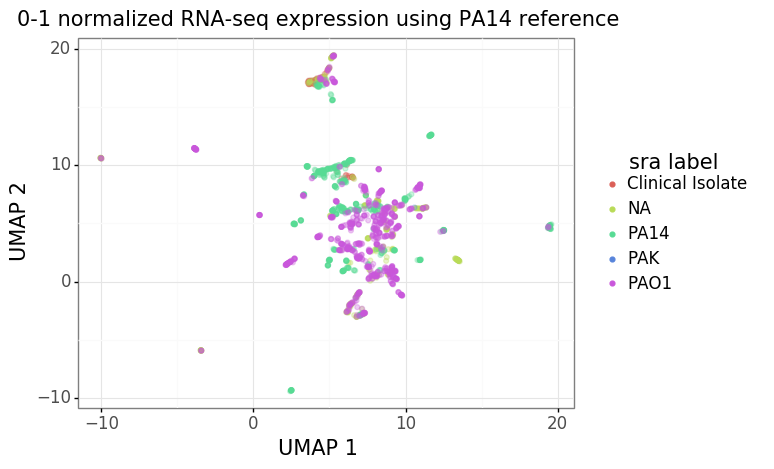

<ggplot: (8750828751081)>


In [39]:
# Plot core gene expression in PA14 reference
normalized_pa14_core_encoded_df["sra label"] = normalized_pa14_core_encoded_df[
    "sra label"
].fillna("NA")
fig6 = pn.ggplot(normalized_pa14_core_encoded_df, pn.aes(x="1", y="2"))
fig6 += pn.geom_point(pn.aes(color="sra label"), alpha=0.3)
fig6 += pn.labs(
    x="UMAP 1",
    y="UMAP 2",
    title="0-1 normalized RNA-seq expression using PA14 reference",
)
fig6 += pn.theme_bw()
fig6 += pn.theme(
    legend_title_align="center",
    plot_background=pn.element_rect(fill="white"),
    legend_key=pn.element_rect(fill="white", colour="white"),
    legend_title=pn.element_text(family="sans-serif", size=15),
    legend_text=pn.element_text(family="sans-serif", size=12),
    plot_title=pn.element_text(family="sans-serif", size=15),
    axis_text=pn.element_text(family="sans-serif", size=12),
    axis_title=pn.element_text(family="sans-serif", size=15),
)
fig6 += pn.guides(colour=pn.guide_legend(override_aes={"alpha": 1}))

print(fig6)

* Samples appear to cluster together. Would have expected more separation between PAO1 and PA14 using core gene expression.

* We also notice that the non-PAO1 and non-PA14 strains fall within the distribution of PAO1 and PA14, so we feel ok retaining them in our analysis (i.e. they shouldn't be outliers when we compare core and accessory gene expression profiles).

## Check

We would have expected most of the variance in the expression data to be due to difference in strain type. Instead we see that most samples cluster together despite different strain types. Let's look at the metadata associated with these samples.

In [40]:
# File containing table to map sample id to strain name
sample_to_strain_filename = paths.SAMPLE_TO_STRAIN

# Load metadata
# Set index to experiment id, which is what we will use to map to expression data
sample_to_strain_table_full = pd.read_csv(sample_to_strain_filename, index_col=2)

In [41]:
# Since experiments have multiple runs there are duplicated experiment ids in the index
# We will need to remove these so that the count calculations are accurate
sample_to_strain_table_full_processed = sample_to_strain_table_full[
    ~sample_to_strain_table_full.index.duplicated(keep="first")
]

In [42]:
# Add study id as a label
pao1_compendium_ids = list(normalized_pao1_core_encoded_df.index)
pa14_compendium_ids = list(normalized_pa14_core_encoded_df.index)

normalized_pao1_core_encoded_df["study id"] = list(
    sample_to_strain_table_full_processed.loc[pao1_compendium_ids, "SRA_study"].values
)
normalized_pa14_core_encoded_df["study id"] = list(
    sample_to_strain_table_full_processed.loc[pa14_compendium_ids, "SRA_study"].values
)

In [43]:
normalized_pao1_core_encoded_df.head()

,1,2,our label,sra label,study id
ERX541572,12.877863,4.201655,PAO1,NA,ERP006680
ERX541573,12.910847,4.157220,PAO1,NA,ERP006680
ERX541574,12.905396,4.165703,PAO1,NA,ERP006680
ERX541575,12.872317,4.195753,PAO1,NA,ERP006680
ERX541576,12.929382,4.138731,PAO1,NA,ERP006680


In [44]:
normalized_pa14_core_encoded_df.head()

,1,2,our label,sra label,study id
ERX1477379,10.386086,7.497775,PA14,PA14,ERP015520
ERX1477380,10.239100,7.344816,PA14,PA14,ERP015520
ERX1477381,10.165520,7.255999,PA14,PA14,ERP015520
ERX2174773,6.743943,6.676329,PA14,PA14,ERP104282
ERX2174774,6.742542,6.672947,PA14,PA14,ERP104282


/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


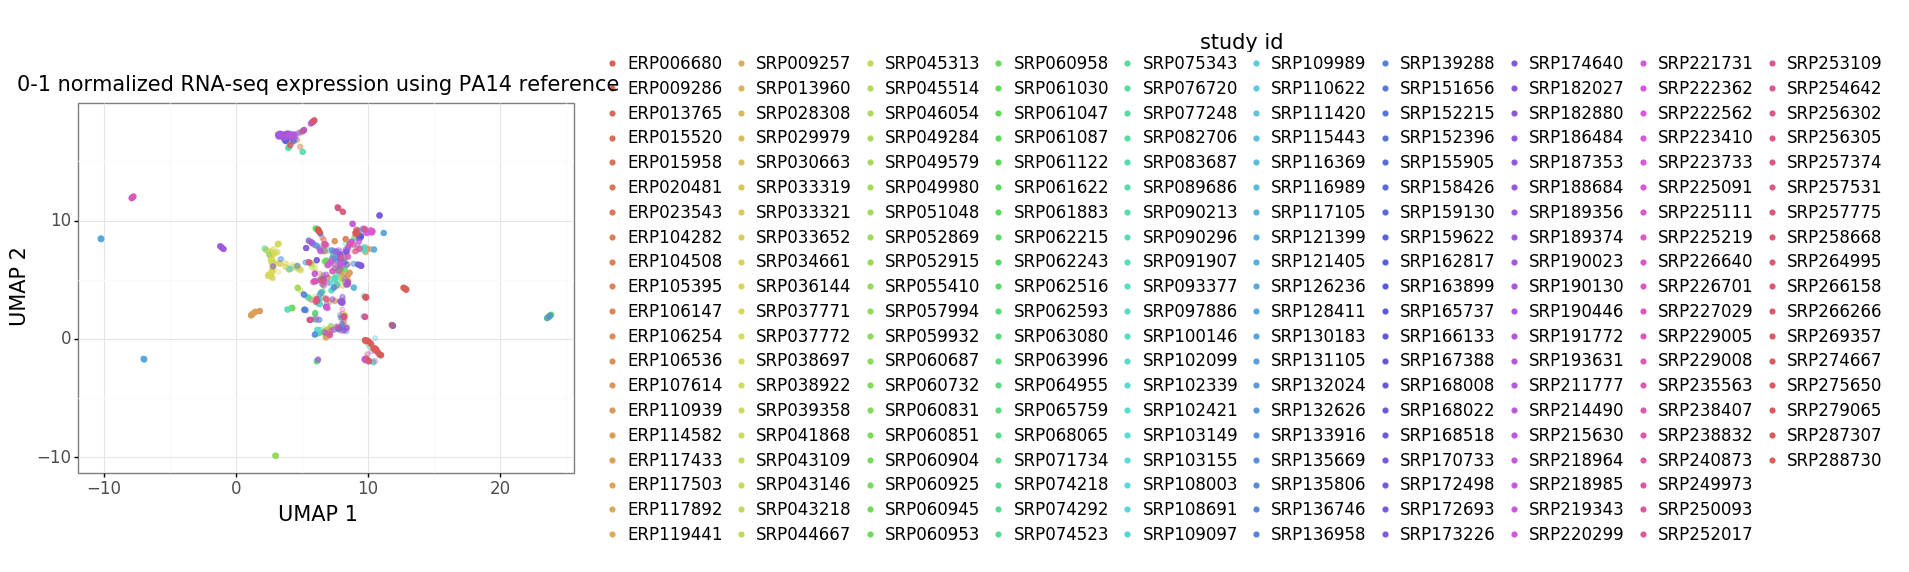

<ggplot: (8750828711221)>


In [45]:
# Plot core gene expression in PA14 reference
fig7 = pn.ggplot(normalized_pao1_core_encoded_df, pn.aes(x="1", y="2"))
fig7 += pn.geom_point(pn.aes(color="study id"), alpha=0.3)
fig7 += pn.labs(
    x="UMAP 1",
    y="UMAP 2",
    title="0-1 normalized RNA-seq expression using PA14 reference",
)
fig7 += pn.theme_bw()
fig7 += pn.theme(
    legend_title_align="center",
    plot_background=pn.element_rect(fill="white"),
    legend_key=pn.element_rect(fill="white", colour="white"),
    legend_title=pn.element_text(family="sans-serif", size=15),
    legend_text=pn.element_text(family="sans-serif", size=12),
    plot_title=pn.element_text(family="sans-serif", size=15),
    axis_text=pn.element_text(family="sans-serif", size=12),
    axis_title=pn.element_text(family="sans-serif", size=15),
)
fig7 += pn.guides(colour=pn.guide_legend(override_aes={"alpha": 1}))

print(fig7)

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


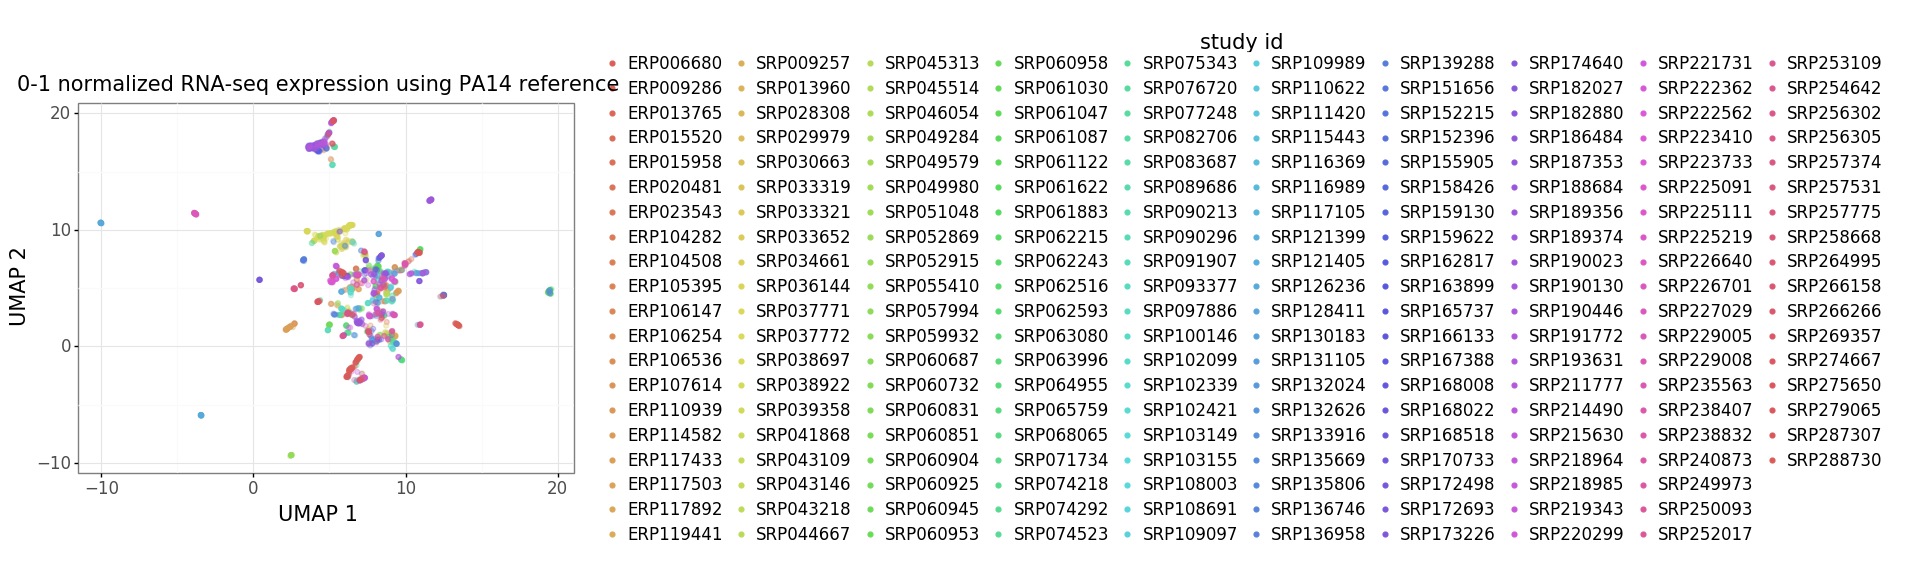

<ggplot: (8750833608937)>


In [46]:
# Plot core gene expression in PA14 reference
fig8 = pn.ggplot(normalized_pa14_core_encoded_df, pn.aes(x="1", y="2"))
fig8 += pn.geom_point(pn.aes(color="study id"), alpha=0.3)
fig8 += pn.labs(
    x="UMAP 1",
    y="UMAP 2",
    title="0-1 normalized RNA-seq expression using PA14 reference",
)
fig8 += pn.theme_bw()
fig8 += pn.theme(
    legend_title_align="center",
    plot_background=pn.element_rect(fill="white"),
    legend_key=pn.element_rect(fill="white", colour="white"),
    legend_title=pn.element_text(family="sans-serif", size=15),
    legend_text=pn.element_text(family="sans-serif", size=12),
    plot_title=pn.element_text(family="sans-serif", size=15),
    axis_text=pn.element_text(family="sans-serif", size=12),
    axis_title=pn.element_text(family="sans-serif", size=15),
)
fig8 += pn.guides(colour=pn.guide_legend(override_aes={"alpha": 1}))

print(fig8)

There are a lot of study ids so its a little hard to see what is happening, but overall it looks like there is clsutering based on study id. I'm still not clear on why there is not more of a separation in the expression data for strain type, but perhaps this will become more clear later.